# Movie Recommendation System using Decision Tree

This notebook implements a movie recommendation system using the **Decision Tree classifier** on the **MovieLens 1M dataset**.

**Approach:**
- Convert movie ratings into a binary classification problem (liked/not liked)
- Use user ID and movie ID as features to train a Decision Tree model
- Apply proper train/test split with feature encoding (fit on train only)
- Predict the probability of a user liking unrated movies
- Recommend movies with the highest predicted "like" probability
- Evaluate using **Precision@K** and **NDCG@K** on test data

**Metrics:**
- Precision@5, Precision@10
- NDCG@5, NDCG@10

## 1. Load and Merge Datasets
Load the MovieLens 1M dataset files (`ratings.dat`, `movies.dat`, `users.dat`) and merge them into a single DataFrame.

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Define data directory
pwd = os.getcwd()
datdir = os.path.join(pwd, '../data/movielens-1m-dataset')

# Load ratings data
ratings_cols = ['userid', 'movieid', 'rating', 'timestamp']
ratings = pd.read_table(os.path.join(datdir, 'ratings.dat'), sep='::', 
                        header=None, names=ratings_cols, engine='python', encoding='latin1')

# Load movies data
movies_cols = ['movieid', 'title', 'genre']
movies = pd.read_table(os.path.join(datdir, 'movies.dat'), sep='::', 
                       header=None, names=movies_cols, engine='python', encoding='latin1')

# Load users data
users_cols = ['userid', 'gender', 'age', 'occupation', 'zip-code']
users = pd.read_table(os.path.join(datdir, 'users.dat'), sep='::', 
                      header=None, names=users_cols, engine='python', encoding='latin1')

# Merge the dataframes
data = pd.merge(pd.merge(ratings, users), movies)

print(f"Dataset loaded successfully!")
print(f"Total ratings: {len(data):,}")
print(f"Unique users: {data['userid'].nunique():,}")
print(f"Unique movies: {data['movieid'].nunique():,}")
data.head()

Dataset loaded successfully!
Total ratings: 1,000,209
Unique users: 6,040
Unique movies: 3,706


,userid,movieid,rating,timestamp,gender,age,occupation,zip-code,title,genre
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy


## 2. Prepare Data for Decision Tree Classification
Convert the continuous rating (1-5) into a binary target variable:
- `liked = 1` if rating >= 4
- `liked = 0` otherwise

In [2]:
# Give the threshold for 'liked' movies
rate = 4

# Create the target variable 'liked' (1 if rating >= rate, else 0)
data['liked'] = (data['rating'] >= rate).astype(int)

# Select features for the model
features = data[['userid', 'movieid']].copy()
target = data['liked']

print("=" * 60)
print("FEATURE SELECTION")
print("=" * 60)
print("Selected features:")
print("   - User ID: userid")
print("   - Movie ID: movieid")
print("\nTarget variable distribution:")
print(target.value_counts())
print(f"\nLiked ratio: {target.mean():.2%}")
print(f"\nFeatures shape: {features.shape}")
features.head()

FEATURE SELECTION
Selected features:
   - User ID: userid
   - Movie ID: movieid

Target variable distribution:
liked
1    575281
0    424928
Name: count, dtype: int64

Liked ratio: 57.52%

Features shape: (1000209, 2)


,userid,movieid
0,1,1193
1,1,661
2,1,914
3,1,3408
4,1,2355


## 3. Time-Based Train/Test Split

Split data by timestamp (80/20) to simulate real-world scenario:
- **Training set**: Earlier 80% of ratings (older timestamps)
- **Test set**: Later 20% of ratings (newer timestamps)

In [3]:
# ============================================================
# TIME-BASED TRAIN/TEST SPLIT
# ============================================================

print("=" * 70)
print("TIME-BASED DATA SPLIT")
print("=" * 70)

# Sort data by timestamp (oldest to newest)
data_sorted = data.sort_values('timestamp').reset_index(drop=True)

# Calculate split point (80% for training, 20% for testing)
split_idx = int(len(data_sorted) * 0.8)

# Split by time: earlier 80% for training, later 20% for testing
train_data = data_sorted.iloc[:split_idx].copy()
test_data = data_sorted.iloc[split_idx:].copy()

# Create features and target for train/test
features_cols = ['userid', 'movieid']
X_train_raw = train_data[features_cols].copy()
X_test_raw = test_data[features_cols].copy()
y_train = train_data['liked'].copy()
y_test = test_data['liked'].copy()

print(f"Total ratings: {len(data_sorted):,}")
print(f"\nTraining set (earlier 80% of ratings):")
print(f"   Size: {len(train_data):,} ({len(train_data)/len(data_sorted)*100:.1f}%)")
print(f"   Users: {train_data['userid'].nunique():,}")
print(f"   Movies: {train_data['movieid'].nunique():,}")
print(f"   Liked ratio: {y_train.mean():.2%}")

print(f"\nTest set (later 20% of ratings):")
print(f"   Size: {len(test_data):,} ({len(test_data)/len(data_sorted)*100:.1f}%)")
print(f"   Users: {test_data['userid'].nunique():,}")
print(f"   Movies: {test_data['movieid'].nunique():,}")
print(f"   Liked ratio: {y_test.mean():.2%}")

# Check user overlap
train_users = set(train_data['userid'].unique())
test_users = set(test_data['userid'].unique())
common_users = list(train_users & test_users)

print(f"\nOverlap Analysis:")
print(f"   Users in both: {len(common_users):,} ({len(common_users)/len(test_users)*100:.1f}% of test users)")

TIME-BASED DATA SPLIT
Total ratings: 1,000,209

Training set (earlier 80% of ratings):
   Size: 800,167 (80.0%)
   Users: 5,400
   Movies: 3,662
   Liked ratio: 57.87%

Test set (later 20% of ratings):
   Size: 200,042 (20.0%)
   Users: 1,783
   Movies: 3,511
   Liked ratio: 56.12%

Overlap Analysis:
   Users in both: 1,143 (64.1% of test users)
Total ratings: 1,000,209

Training set (earlier 80% of ratings):
   Size: 800,167 (80.0%)
   Users: 5,400
   Movies: 3,662
   Liked ratio: 57.87%

Test set (later 20% of ratings):
   Size: 200,042 (20.0%)
   Users: 1,783
   Movies: 3,511
   Liked ratio: 56.12%

Overlap Analysis:
   Users in both: 1,143 (64.1% of test users)


## 4. Feature Encoding

Encode categorical features using LabelEncoder (fit only on training data).

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# ============================================================
# FEATURE TRANSFORMER CLASS
# ============================================================

class FeatureTransformer:
    """Handle feature encoding with proper train/test separation."""
    
    def __init__(self, feature_cols):
        self.encoders = {}
        self.encoder_maps = {}
        self.feature_cols = feature_cols
        self.is_fitted = False
        
    def fit(self, X_train):
        """Fit encoders on training data only."""
        for col in self.feature_cols:
            le = LabelEncoder()
            le.fit(X_train[col].astype(str))
            self.encoders[col] = le
            self.encoder_maps[col] = {c: i for i, c in enumerate(le.classes_)}
            print(f"Encoded '{col}': {len(le.classes_)} unique values")
        self.is_fitted = True
        return self
    
    def transform(self, X):
        """Transform features using fitted encoders."""
        if not self.is_fitted:
            raise ValueError("Transformer not fitted. Call fit() first.")
        X_encoded = X.copy()
        for col in self.feature_cols:
            X_encoded[col] = X[col].astype(str).map(self.encoder_maps[col]).fillna(0).astype(int)
        return X_encoded
    
    def encode_batch_fast(self, df):
        """Encode DataFrame for fast batch prediction."""
        result = np.zeros((len(df), len(self.feature_cols)), dtype=np.int32)
        for i, col in enumerate(self.feature_cols):
            values = df[col].astype(str).values
            encoded = np.array([self.encoder_maps[col].get(str(v), 0) for v in values])
            result[:, i] = encoded
        return result

# ============================================================
# FIT TRANSFORMER ON TRAINING DATA
# ============================================================

print("=" * 60)
print("FITTING TRANSFORMERS ON TRAINING DATA ONLY")
print("=" * 60)

transformer = FeatureTransformer(features_cols)
transformer.fit(X_train_raw)

# Transform training and test data
X_train_encoded = transformer.transform(X_train_raw)
X_test_encoded = transformer.transform(X_test_raw)

print(f"\nX_train_encoded shape: {X_train_encoded.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")

FITTING TRANSFORMERS ON TRAINING DATA ONLY
Encoded 'userid': 5400 unique values
Encoded 'userid': 5400 unique values
Encoded 'movieid': 3662 unique values
Encoded 'movieid': 3662 unique values

X_train_encoded shape: (800167, 2)
X_test_encoded shape: (200042, 2)

X_train_encoded shape: (800167, 2)
X_test_encoded shape: (200042, 2)


## 5. Train Decision Tree Model

Train a Decision Tree classifier with hyperparameter tuning.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ============================================================
# TRAIN DECISION TREE WITH HYPERPARAMETER TUNING
# ============================================================

print("=" * 60)
print("TRAINING DECISION TREE MODEL")
print("=" * 60)

# Test different max_depth values
depth_values = [5, 10, 15, 20, 25]
best_depth = 10
best_score = 0

print("Testing different max_depth values...")
for depth in depth_values:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42, min_samples_split=10)
    dt_temp.fit(X_train_encoded, y_train)
    score = dt_temp.score(X_train_encoded, y_train)
    test_score = dt_temp.score(X_test_encoded, y_test)
    print(f"   max_depth={depth}: Train acc = {score:.4f}, Test acc = {test_score:.4f}")
    if test_score > best_score:
        best_score = test_score
        best_depth = depth

print(f"\n✓ Selected max_depth = {best_depth}")

# Train final model
dt_model = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dt_model.fit(X_train_encoded, y_train)

print(f"\nModel trained successfully!")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")

TRAINING DECISION TREE MODEL
Testing different max_depth values...
   max_depth=5: Train acc = 0.5869, Test acc = 0.5707
   max_depth=5: Train acc = 0.5869, Test acc = 0.5707
   max_depth=10: Train acc = 0.6193, Test acc = 0.5983
   max_depth=10: Train acc = 0.6193, Test acc = 0.5983
   max_depth=15: Train acc = 0.6672, Test acc = 0.6253
   max_depth=15: Train acc = 0.6672, Test acc = 0.6253
   max_depth=20: Train acc = 0.7116, Test acc = 0.6252
   max_depth=20: Train acc = 0.7116, Test acc = 0.6252
   max_depth=25: Train acc = 0.7567, Test acc = 0.6084

✓ Selected max_depth = 15
   max_depth=25: Train acc = 0.7567, Test acc = 0.6084

✓ Selected max_depth = 15

Model trained successfully!
Tree depth: 15
Number of leaves: 7029

Model trained successfully!
Tree depth: 15
Number of leaves: 7029


## 6. Evaluate the Model

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
y_pred = dt_model.predict(X_test_encoded)

print("=" * 50)
print("MODEL EVALUATION RESULTS")
print("=" * 50)
print(f"\nAccuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")

print("\n" + "-" * 50)
print("Classification Report:")
print("-" * 50)
print(classification_report(y_test, y_pred, target_names=['Not Liked (0)', 'Liked (1)']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

MODEL EVALUATION RESULTS

Accuracy:  0.6375
Precision: 0.6532
Recall:    0.7548
F1-Score:  0.7003

--------------------------------------------------
Classification Report:
--------------------------------------------------
               precision    recall  f1-score   support

Not Liked (0)       0.61      0.49      0.54     87781
    Liked (1)       0.65      0.75      0.70    112261

     accuracy                           0.64    200042
    macro avg       0.63      0.62      0.62    200042
 weighted avg       0.63      0.64      0.63    200042

Confusion Matrix:
[[42802 44979]
 [27529 84732]]
               precision    recall  f1-score   support

Not Liked (0)       0.61      0.49      0.54     87781
    Liked (1)       0.65      0.75      0.70    112261

     accuracy                           0.64    200042
    macro avg       0.63      0.62      0.62    200042
 weighted avg       0.63      0.64      0.63    200042

Confusion Matrix:
[[42802 44979]
 [27529 84732]]


## 7. Recommendation Functions

In [8]:
# ============================================================
# RECOMMENDATION FUNCTIONS
# ============================================================

# Pre-compute caches for speed
user_rated_movies_cache = train_data.groupby('userid')['movieid'].apply(set).to_dict()
all_train_movies_set = set(train_data['movieid'].unique())

def get_recommendations(userid, n_recommendations=10):
    """
    Generate movie recommendations using Decision Tree.
    
    Parameters:
    -----------
    userid : int
        The user ID to generate recommendations for
    n_recommendations : int
        Number of movies to recommend
    
    Returns:
    --------
    tuple : (list of movie IDs, list of probabilities)
    """
    # Get movies the user has NOT rated
    user_movies = user_rated_movies_cache.get(userid, set())
    candidate_movies = list(all_train_movies_set - user_movies)
    
    if len(candidate_movies) == 0:
        return [], []
    
    # Create feature DataFrame
    n_candidates = len(candidate_movies)
    candidate_df = pd.DataFrame({
        'userid': np.full(n_candidates, userid),
        'movieid': candidate_movies
    })
    
    # Encode features
    encoded_features = transformer.encode_batch_fast(candidate_df)
    
    # Predict probabilities
    proba = dt_model.predict_proba(encoded_features)[:, 1]
    
    # Get top N
    if n_recommendations < len(proba):
        top_indices = np.argpartition(proba, -n_recommendations)[-n_recommendations:]
        top_indices = top_indices[np.argsort(proba[top_indices])[::-1]]
    else:
        top_indices = np.argsort(proba)[::-1][:n_recommendations]
    
    recommended_movies = [candidate_movies[i] for i in top_indices]
    probas = proba[top_indices].tolist()
    
    return recommended_movies, probas


def get_movie_title(movie_id):
    """Get movie title from movies DataFrame."""
    movie_row = movies[movies['movieid'] == movie_id]
    if len(movie_row) > 0:
        return movie_row.iloc[0]['title']
    return f"Unknown Movie (ID: {movie_id})"


def get_movie_info(movie_id):
    """Get detailed movie info."""
    movie_row = movies[movies['movieid'] == movie_id]
    if len(movie_row) > 0:
        return {
            'movieid': movie_id,
            'title': movie_row.iloc[0]['title'],
            'genre': movie_row.iloc[0]['genre']
        }
    return None


# ============================================================
# TEST RECOMMENDATIONS
# ============================================================

sample_user = train_data['userid'].iloc[0]
print("=" * 70)
print(f"DECISION TREE RECOMMENDATION SYSTEM")
print("=" * 70)
print(f"\nTesting for User {sample_user}:\n")

import time
start = time.time()
recs, probs = get_recommendations(sample_user, n_recommendations=5)
elapsed = (time.time() - start) * 1000
print(f"⚡ Time: {elapsed:.2f} ms\n")

print("Top 5 Recommendations:")
print("-" * 60)
for i, (movie_id, prob) in enumerate(zip(recs, probs), 1):
    info = get_movie_info(movie_id)
    if info:
        print(f"  {i}. {info['title'][:45]:<45} P={prob:.3f}")

DECISION TREE RECOMMENDATION SYSTEM

Testing for User 6040:

⚡ Time: 56.59 ms

Top 5 Recommendations:
------------------------------------------------------------
  1. Cotton Mary (1999)                            P=1.000
  2. Bluebeard (1944)                              P=1.000
  3. Circus, The (1928)                            P=1.000
  4. Rain (1932)                                   P=1.000
  5. Sanjuro (1962)                                P=1.000


## 8. Ranking Metrics (Precision@K, NDCG@K)

In [9]:
# ============================================================
# RANKING METRICS FUNCTIONS
# ============================================================

def precision_at_k(recommended_items, relevant_items, k):
    """
    Calculate Precision@K.
    Formula: Precision@K = |recommended ∩ relevant| / K
    """
    if k <= 0:
        return 0.0
    top_k = recommended_items[:k]
    relevant_in_top_k = len(set(top_k) & set(relevant_items))
    return relevant_in_top_k / k


def ndcg_at_k(recommended_items, relevant_items, k):
    """
    Calculate NDCG@K (Normalized Discounted Cumulative Gain).
    """
    if k <= 0:
        return 0.0
    
    top_k = recommended_items[:k]
    
    # Calculate DCG@K
    dcg = 0.0
    for i, item in enumerate(top_k):
        if item in relevant_items:
            dcg += 1.0 / np.log2(i + 2)
    
    # Calculate IDCG@K (ideal DCG)
    num_relevant = min(len(relevant_items), k)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(num_relevant))
    
    if idcg == 0:
        return 0.0
    
    return dcg / idcg


print("Ranking metrics functions defined:")
print("  - precision_at_k(recommended_items, relevant_items, k)")
print("  - ndcg_at_k(recommended_items, relevant_items, k)")

Ranking metrics functions defined:
  - precision_at_k(recommended_items, relevant_items, k)
  - ndcg_at_k(recommended_items, relevant_items, k)


In [10]:
def evaluate_recommendations_for_user(userid, n_recommendations=20):
    """
    Evaluate recommendation quality for a single user using TEST DATA.
    """
    if userid not in train_data['userid'].values:
        return None
    if userid not in test_data['userid'].values:
        return None
    
    # Get recommendations
    recommended_movie_ids, probs = get_recommendations(userid, n_recommendations)
    
    if recommended_movie_ids is None or len(recommended_movie_ids) == 0:
        return None
    
    # Get ground truth: movies user ACTUALLY LIKED in TEST DATA
    user_test_data = test_data[test_data['userid'] == userid]
    actually_liked_movies = set(user_test_data[user_test_data['liked'] == 1]['movieid'].tolist())
    
    if len(actually_liked_movies) == 0:
        return None
    
    # Calculate metrics
    metrics = {
        'userid': userid,
        'num_test_ratings': len(user_test_data),
        'num_liked_in_test': len(actually_liked_movies),
        'precision_at_5': precision_at_k(recommended_movie_ids, actually_liked_movies, 5),
        'precision_at_10': precision_at_k(recommended_movie_ids, actually_liked_movies, 10),
        'ndcg_at_5': ndcg_at_k(recommended_movie_ids, actually_liked_movies, 5),
        'ndcg_at_10': ndcg_at_k(recommended_movie_ids, actually_liked_movies, 10),
    }
    
    return metrics


print("Evaluation function defined!")

Evaluation function defined!


## 9. Evaluate on Multiple Users

In [11]:
import random
from tqdm import tqdm

# ============================================================
# EVALUATE ON MULTIPLE USERS
# ============================================================

def evaluate_model_on_users(user_ids, n_recommendations=20, verbose=True):
    """
    Evaluate the recommendation model on multiple users.
    """
    all_metrics = []
    
    iterator = tqdm(user_ids, desc="Evaluating users") if verbose else user_ids
    
    for userid in iterator:
        metrics = evaluate_recommendations_for_user(userid, n_recommendations)
        if metrics:
            all_metrics.append(metrics)
    
    if len(all_metrics) == 0:
        print("No users could be evaluated!")
        return None, None
    
    # Calculate average metrics
    metric_names = ['precision_at_5', 'precision_at_10', 'ndcg_at_5', 'ndcg_at_10']
    
    avg_metrics = {
        'num_users_evaluated': len(all_metrics),
        'total_users_attempted': len(user_ids)
    }
    
    for metric in metric_names:
        values = [m[metric] for m in all_metrics]
        avg_metrics[f'avg_{metric}'] = np.mean(values)
        avg_metrics[f'std_{metric}'] = np.std(values)
    
    return avg_metrics, all_metrics


# ============================================================
# RUN EVALUATION
# ============================================================

common_users_list = list(set(train_data['userid'].unique()) & set(test_data['userid'].unique()))
sample_size = min(1000, len(common_users_list))

random.seed(42)
sample_users = random.sample(common_users_list, sample_size)

print("=" * 70)
print(f"DECISION TREE MODEL EVALUATION")
print("=" * 70)
print(f"\nEvaluating on {sample_size} users from test set...")

avg_metrics, all_metrics = evaluate_model_on_users(sample_users, n_recommendations=20)

if avg_metrics:
    print(f"\n{'='*70}")
    print("SUMMARY RESULTS")
    print(f"{'='*70}")
    print(f"Users evaluated: {avg_metrics['num_users_evaluated']} / {avg_metrics['total_users_attempted']}")
    
    print(f"\n{'Metric':<20} {'Mean':<12} {'Std Dev':<12}")
    print("-" * 45)
    print(f"{'Precision@5':<20} {avg_metrics['avg_precision_at_5']:.4f}       ±{avg_metrics['std_precision_at_5']:.4f}")
    print(f"{'Precision@10':<20} {avg_metrics['avg_precision_at_10']:.4f}       ±{avg_metrics['std_precision_at_10']:.4f}")
    print(f"{'NDCG@5':<20} {avg_metrics['avg_ndcg_at_5']:.4f}       ±{avg_metrics['std_ndcg_at_5']:.4f}")
    print(f"{'NDCG@10':<20} {avg_metrics['avg_ndcg_at_10']:.4f}       ±{avg_metrics['std_ndcg_at_10']:.4f}")
    print("-" * 45)

DECISION TREE MODEL EVALUATION

Evaluating on 1000 users from test set...


Evaluating users: 100%|██████████| 1000/1000 [00:54<00:00, 18.28it/s]


SUMMARY RESULTS
Users evaluated: 984 / 1000

Metric               Mean         Std Dev     
---------------------------------------------
Precision@5          0.0264       ±0.0773
Precision@10         0.0259       ±0.0560
NDCG@5               0.0267       ±0.0855
NDCG@10              0.0271       ±0.0668
---------------------------------------------


## 10. Visualize Metrics Distribution

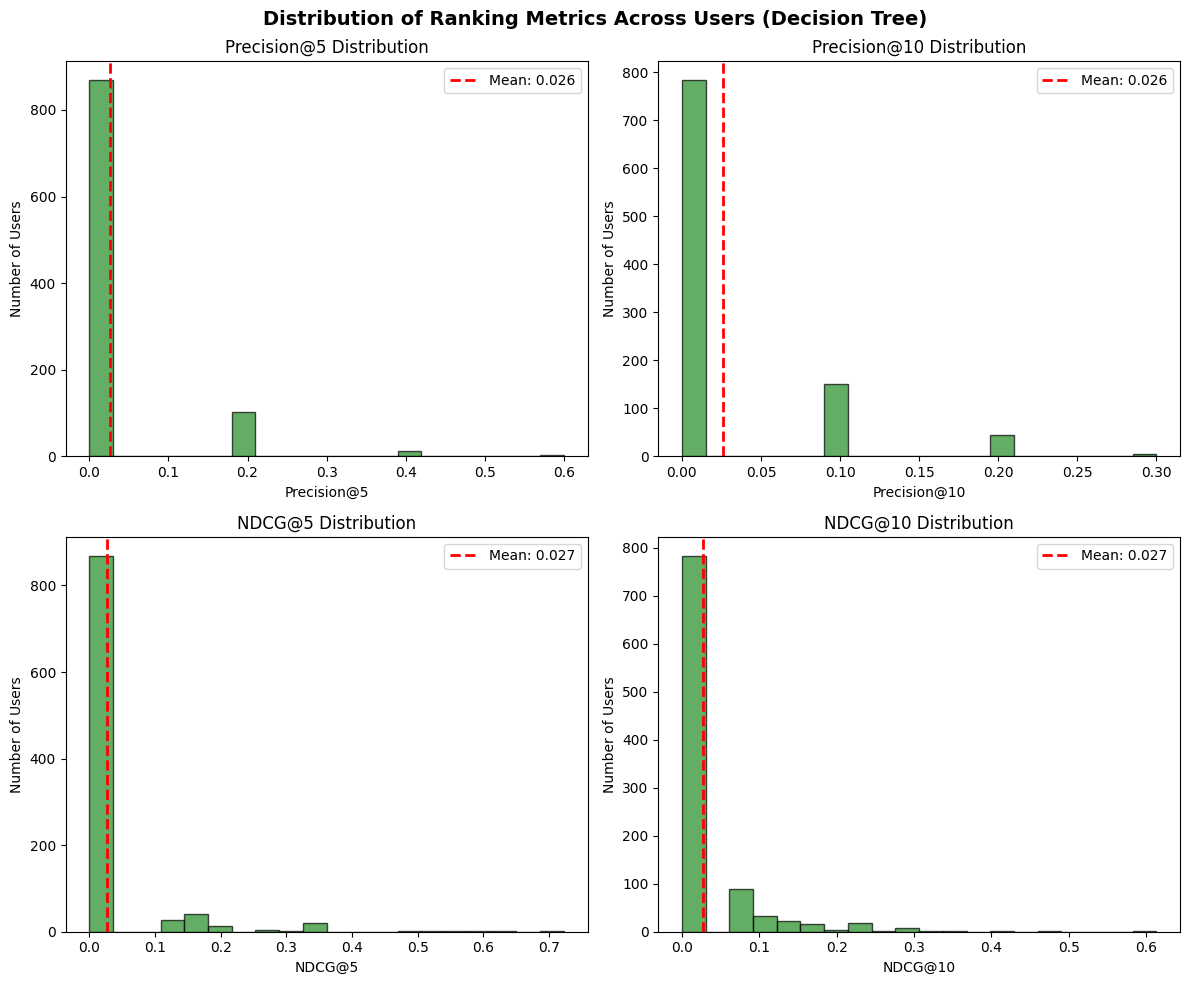


DETAILED STATISTICS

Precision@5:
   Min: 0.0000, Max: 0.6000
   Mean: 0.0264, Median: 0.0000
   Std: 0.0773

Precision@10:
   Min: 0.0000, Max: 0.3000
   Mean: 0.0259, Median: 0.0000
   Std: 0.0560

NDCG@5:
   Min: 0.0000, Max: 0.7227
   Mean: 0.0267, Median: 0.0000
   Std: 0.0855

NDCG@10:
   Min: 0.0000, Max: 0.6131
   Mean: 0.0271, Median: 0.0000
   Std: 0.0668


In [12]:
import matplotlib.pyplot as plt

# ============================================================
# VISUALIZE METRICS DISTRIBUTION
# ============================================================

if all_metrics:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Distribution of Ranking Metrics Across Users (Decision Tree)', fontsize=14, fontweight='bold')
    
    metrics_to_plot = [
        ('precision_at_5', 'Precision@5', axes[0, 0]),
        ('precision_at_10', 'Precision@10', axes[0, 1]),
        ('ndcg_at_5', 'NDCG@5', axes[1, 0]),
        ('ndcg_at_10', 'NDCG@10', axes[1, 1]),
    ]
    
    for metric_key, metric_name, ax in metrics_to_plot:
        values = [m[metric_key] for m in all_metrics]
        ax.hist(values, bins=20, edgecolor='black', alpha=0.7, color='forestgreen')
        ax.axvline(np.mean(values), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(values):.3f}')
        ax.set_xlabel(metric_name)
        ax.set_ylabel('Number of Users')
        ax.set_title(f'{metric_name} Distribution')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "=" * 70)
    print("DETAILED STATISTICS")
    print("=" * 70)
    
    for metric_key, metric_name, _ in metrics_to_plot:
        values = [m[metric_key] for m in all_metrics]
        print(f"\n{metric_name}:")
        print(f"   Min: {np.min(values):.4f}, Max: {np.max(values):.4f}")
        print(f"   Mean: {np.mean(values):.4f}, Median: {np.median(values):.4f}")
        print(f"   Std: {np.std(values):.4f}")

## 11. Summary

### Decision Tree Recommendation System

**Model Characteristics:**
- Uses binary splits on features to make predictions
- Captures non-linear relationships between users and movies
- Interpretable through tree visualization
- Hyperparameters: max_depth, min_samples_split, min_samples_leaf

**Evaluation Metrics:**
- **Precision@K**: Proportion of recommended items that are relevant
- **NDCG@K**: Considers both relevance and ranking position

**Key Features:**
- Time-based train/test split (realistic evaluation)
- Feature encoding with LabelEncoder
- Batch prediction for fast recommendations